In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import emcee
import corner
import datetime

clight = 299792.458  # speed of light in km/s

In [2]:
# analysis parameters to be varied
sample = "cardona"  # sample cuts to make (see below)
nscatter = 1 # number of intrinsic scatter parameters (0: none, 1: same for all SN; 2: separate calib/hflow)
redshift = "nedfinal" # choices are "literature", "nedhost", "nedfinal", or "flowcorr" 
pecvel_unc = 150.0   # peculiar velocity uncertainty in km/s
distmode = "kinematic"  # use kinematic (q0,j0) or dynamic (Om,Ol) luminosity distance formula
use_median = False # set the Hubble residual and calibrator zeropoints relative to median rather than weighted mean
individual_plots = False # make separate PDFs of each plot, in addition to combined PDF

In [3]:
# cuts list: morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile
samples = { "fiducial":   ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"), 
            "lowebv":     ( -9,  9, -9, 0.3,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
            "spirals":    (1.9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
            "lowmwaj":    ( -9,  9, -9,   9,  -9, 1.5,   -9,    9, 0.3, "calibrators.dat", "hubbleflow.dat"),
            "vlowmwaj":   ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,0.15, "calibrators.dat", "hubbleflow.dat"),
            "restricted": (1.9,  9, -9, 0.3,  -9, 1.3,   -9,    9, 0.3, "calibrators.dat", "hubbleflow.dat"),
            "stringent":  (1.9,  9, -9, 0.3, 1.0, 1.2,   -9,    9,0.15, "calibrators.dat", "hubbleflow.dat"),
            "all":        ( -9,  9, -9,   9,  -9,   9,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
            "z02":        ( -9,  9, -9,   9,  -9, 1.5, 0.02,    9,   9, "calibrators.dat", "hubbleflow.dat"),
            "z025":       ( -9,  9, -9,   9,  -9, 1.5, 0.025,   9,   9, "calibrators.dat", "hubbleflow.dat"),
            "z03":        ( -9,  9, -9,   9,  -9, 1.5, 0.03,    9,   9, "calibrators.dat", "hubbleflow.dat"),
            "z07":        ( -9,  9, -9,   9,  -9, 1.5,   -9, 0.07,   9, "calibrators.dat", "hubbleflow.dat"),
            "z0207":      ( -9,  9, -9,   9,  -9, 1.5, 0.02, 0.07,   9, "calibrators.dat", "hubbleflow.dat"),
            "csp":        ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow_CSP.dat"),
            "cspall":     ( -9,  9, -9,   9,  -9,   9,   -9,    9,   9, "calibrators.dat", "hubbleflow_CSP.dat"),
            "csp_calhf":  ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators_CSP.dat", "hubbleflow_CSP.dat"),
            "cfa":        ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow_CfA.dat"),
            "cfa_calhf":  ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators_CfA.dat", "hubbleflow_CfA.dat"),
            "cardona":    ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators_Cardona.dat", "hubbleflow.dat"),
          }

morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile = samples.get(sample) 

print(morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile)

# data for calibrators
calib_datafile = calibfile  

# data for Hubble flow objects
hflow_datafile = hflowfile 

-9 9 -9 9 -9 1.5 -9 9 9 calibrators_Cardona.dat hubbleflow.dat


In [4]:
# output plots will start with this prefix
pdf_basename = "H0-" + sample

# create output file name

if nscatter == 0:
    pdf_basename += "-noscatter"
elif nscatter == 1:
    pass
elif nscatter == 2:
    pdf_basename += "-twoscatter"
else:
    raise ValueError("nscatter should be 0, 1, or 2")    

pdf_basename += "-z" + redshift
pdf_basename += "-sigcz=" + "{:.0f}".format(pecvel_unc)

if use_median:
    pdf_basename += '-median'

if distmode == "dynamic":
    pdf_basename += "-dynamic"

print(pdf_basename)

H0-cardona-znedfinal-sigcz=150


In [5]:
# function to convert peculiar velocity uncertainty (km/s) into magnitudes
#    this includes a small "correction factor" that accounts for the nonlinearity in a std LCDM cosmology
#    the correction factor is negligible at low redshift
def pverr2mag(z,pverr,correction=True):

    if correction:
        assert ((np.min(z) >= 0) and (np.max(z) <= 3)),"Correction factor defined for z=0-3 only"
        correction_coeffs = [1.00171318, 0.74494186, -0.97690614, 0.69153719, -0.28044894, 
                             0.06058092, -0.00537420]
        corrfactor = np.polyval(correction_coeffs[::-1],z)
    else:
        corrfactor = 1.0
        
    return 5.0/np.log(10.0)*pverr/299792.458/z*corrfactor

In [6]:
# function to return distance modulus mu(z) assuming H0=70
#   mode="dynamic" uses flat LCDM cosmology with Om=0.3, Om=0.7 (+ photons,neutrinos)
#   mode="kinematic" uses approximation with q0=-0.55, j0=1
#   negligible difference between these at low redshift
def distmod70(z,mode="dynamic"):
    if mode == "dynamic":
        cosmo = FlatLambdaCDM(H0=70.0, Om0=0.3)
        return 5.0 * np.log10(cosmo.luminosity_distance(z)/u.Mpc) + 25.0
    elif mode == "kinematic":
        q0 = -0.55
        j0 = 1.0
        return 5.0 * np.log10(299792.458*z/70.0 *
                              (1 + (1 - q0)*z/2.0 
                               - (1 - q0 - 3*q0**2 + j0)*(z**2)/6.0)) + 25.0
    else:
        raise ValueError("Undefined mode")    

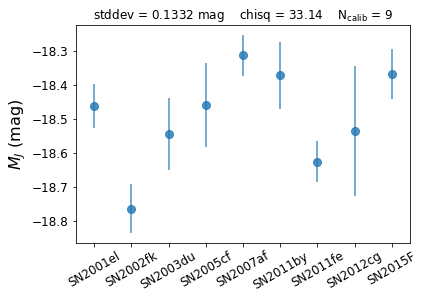

In [7]:
# calibrators
calib_readin = np.genfromtxt(calib_datafile, dtype=None, 
                             names="SN,mag,magerr,mu,muerr,absM,absMerr,ebv,dm15,host,hostmorph,morph,mwaj,ref,sample")

# apply sample cuts
good = (  (calib_readin["ebv"] >= ebvmin) & (calib_readin["ebv"] <= ebvmax)
        & (calib_readin["morph"] >= morphmin) & (calib_readin["morph"] <= morphmax)
        & (calib_readin["dm15"] >= dm15min) & (calib_readin["dm15"] <= dm15max)
        & (calib_readin["mwaj"] <= mwajmax))
calib_readin = calib_readin[good]

calib_unc = calib_readin["absMerr"]
calib_data = calib_readin["absM"]
calib_SN = np.char.decode(calib_readin["SN"])
ncalib = len(calib_data)

calib_wtmean = np.average(calib_data,weights=calib_unc**(-2))
cpull = (calib_data - calib_wtmean)/calib_unc
cchisq = np.sum(cpull**2)
sigcalib = np.std(calib_data)

# plot calibrators
x = np.arange(ncalib)
figcalib = plt.figure(figsize=(6,4))
plt.errorbar(x,calib_data,yerr=calib_unc,marker='o',linestyle='none',ms=8.,alpha=0.8)
plt.xticks(x,calib_SN,rotation=30,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"$M_J$ (mag)", fontsize=16)
plt.xlim((-0.5,ncalib-0.5))
plt.title("stddev = " + "{:.4f}".format(sigcalib) + " mag" 
          + "    chisq = " + "{:.2f}".format(cchisq)
          + "    N$_\mathrm{calib}$ = " + "{:d}".format(ncalib))
if individual_plots:
    plt.savefig(pdf_basename+"_calibM.pdf",bbox_inches="tight")
plt.show()

In [8]:
# sanity checks of the file
testabsM = calib_readin["mag"] - calib_readin["mu"]
testerr = np.sqrt(calib_readin["magerr"]**2 + calib_readin["muerr"]**2) 

if np.max(np.abs(testabsM-calib_data)) > 1e-10:
    print("calibrator absolute magnitude doesn't match calculated value?!")

if np.max(np.abs(testerr-calib_unc)) > 5e-4:
    print("calibrator absolute magnitude uncertainty doesn't match calculated value?!")
    
# no output if things are okay

In [9]:
## Hubble flow objects
hflow_readin = np.genfromtxt(hflow_datafile,dtype=None,
                             names="SN,zlit,zned,znederr,znedfinal,znedfinalerr,zflowcorrected," +
                             "mag,magerr,ebv,dm15,host,hostmorph,morph,mwaj,survey")

if redshift == "literature":
    zobstr = "zlit"
elif redshift == "nedhost":
    zobstr = "zned"
    zerrstr = "znederr"
elif redshift == "nedfinal":
    zobstr = "znedfinal"
    zerrstr = "znedfinalerr"
elif redshift == "flowcorr":
    zobstr = "zflowcorrected"
    zerrstr = "znedfinalerr"
else: 
    raise ValueError("Undefined redshift type")

# apply sample cuts
hgood = (  (hflow_readin["ebv"] >= ebvmin) & (hflow_readin["ebv"] <= ebvmax)
         & (hflow_readin["morph"] >= morphmin) & (hflow_readin["morph"] <= morphmax)
         & (hflow_readin["dm15"] >= dm15min) & (hflow_readin["dm15"] <= dm15max) 
         & (hflow_readin[zobstr] >= zmin) & (hflow_readin[zobstr] <= zmax) 
         & (hflow_readin["mwaj"] <= mwajmax) )
hflow_readin = hflow_readin[hgood]

hflow_data = hflow_readin["mag"]
hflow_ptunc = hflow_readin["magerr"]
nhflow = len(hflow_data)

hflow_zobs = hflow_readin[zobstr]
if redshift == "literature":
    hflow_zerr = 0.
else:
    hflow_zerr = hflow_readin[zerrstr]
    
hflow_verr = hflow_zerr * clight

# total z error is redshift measurement uncertainty plus peculiar velocity uncertainty
hflow_totverr = np.sqrt(hflow_verr**2 + pecvel_unc**2)
hflow_totzerr = hflow_totverr / clight

# convert z error into magnitudes
hflow_pvmagerr = pverr2mag(hflow_zobs,hflow_totverr)
hflow_unc = np.sqrt(hflow_ptunc**2 + hflow_pvmagerr**2)

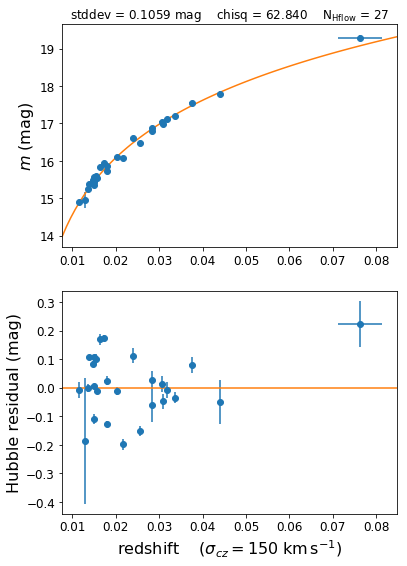

In [10]:
# for the likelihood function, we pass in the Hubble flow data as the absolute magnitude assuming H0=70
# the best fit H0 is based on the difference between these and the calibrator absolute magnitudes
hflow_mu70 = distmod70(hflow_zobs,mode=distmode)
hflow_M70 = hflow_data - hflow_mu70

# calculate Hubble residuals
hflow_wtmeanM = np.average(hflow_M70,weights=hflow_unc**(-2))
hr = hflow_M70 - hflow_wtmeanM
# use median?
if use_median:
    hr -= np.median(hr)

hpull = hr/hflow_unc
hchisq = np.sum(hpull**2)
sighr = np.std(hr)

htitle = ("stddev = " + "{:.4f}".format(sighr) + " mag" 
          + "    chisq = " + "{:.3f}".format(hchisq)
          + "    N$_\mathrm{Hflow}$ = " + "{:d}".format(nhflow))
hxlabel = (r"redshift    ($\sigma_{cz} = " + "{:.0f}".format(pecvel_unc) 
           + r"\;\mathrm{km\,s}^{-1}$)") 

# plot Hubble diagram & residuals
fighflow = plt.figure(figsize=(6,9))
plt.subplot('211')
plt.errorbar(hflow_zobs,hflow_data,yerr=hflow_ptunc,xerr=hflow_totzerr,marker='o',linestyle='none')
plt.ylabel(r"$m$ (mag)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
zlim = plt.xlim()
zz = np.arange(zlim[0],zlim[1]+0.002,0.001)
plt.plot(zz,distmod70(zz,mode=distmode)+hflow_wtmeanM)
plt.xlim(zlim)
plt.title(htitle)

plt.subplot('212')
plt.errorbar(hflow_zobs,hr,yerr=hflow_ptunc,xerr=hflow_totzerr,marker='o',linestyle='none')
plt.xlabel(hxlabel,fontsize=16)
plt.ylabel(r"Hubble residual (mag)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(zlim,[0,0])
plt.xlim(zlim)
if individual_plots:
    plt.savefig(pdf_basename+"_hubblediagram.pdf",bbox_inches="tight")
plt.show()

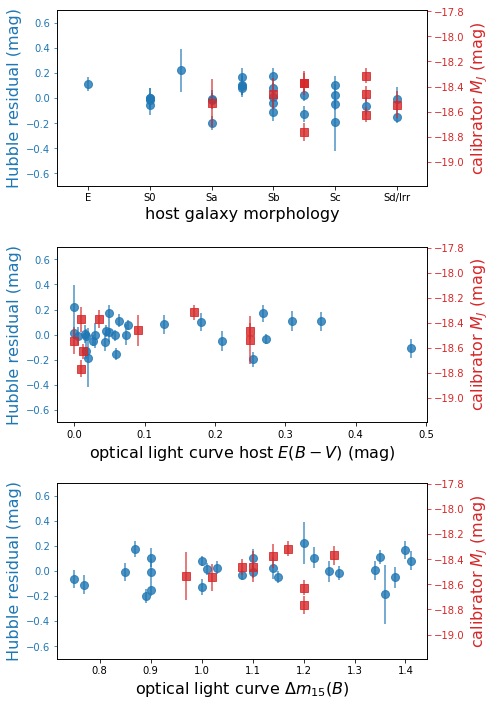

In [11]:
# diagnostic plots comparing calibrators and Hubble flow objects

calib_ebv = calib_readin["ebv"]
calib_dm15 = calib_readin["dm15"]
calib_morph = calib_readin["morph"]

hflow_ebv = hflow_readin["ebv"]
hflow_dm15 = hflow_readin["dm15"]
hflow_morph = hflow_readin["morph"]

figall_diag = plt.figure(figsize=(7,10))

ylim = np.array([-0.7,0.7])
calib_wtmeanM = np.average(calib_data,weights=calib_unc**(-2))

if use_median:
    calib_zp = np.median(calib_data)
else:
    calib_zp = calib_wtmeanM

plt.subplot2grid((3,1), (0,0))
plt.errorbar(hflow_morph,hr,yerr=hflow_unc,marker='o',linestyle='none',alpha=0.8,label='Hubble flow',ms=8.)
plt.ylabel(r"Hubble residual (mag)",fontsize=16,color='C0')
plt.xlabel(r"host galaxy morphology", fontsize=16)
plt.ylim(ylim)
plt.tick_params('y', colors='C0')
ax2 = plt.twinx()
ax2.errorbar(calib_morph,calib_data,yerr=calib_unc,marker='s',linestyle='none',color='C3'
             ,alpha=0.8,label='calibrator',ms=8.)
plt.ylabel(r"calibrator $M_J$ (mag)", fontsize=16, color='C3')
ax2.tick_params('y', colors='C3')
plt.xlim([-0.5,5.5])
plt.ylim(ylim+calib_zp)
plt.xticks([0,1,2,3,4,5],['E','S0','Sa','Sb','Sc','Sd/Irr'])

plt.subplot2grid((3,1), (1,0))
plt.errorbar(hflow_ebv,hr,yerr=hflow_unc,marker='o',linestyle='none',alpha=0.8,label='Hubble flow',ms=8.)
plt.ylabel(r"Hubble residual (mag)",fontsize=16,color='C0')
plt.xlabel(r"optical light curve host $E(B-V)$ (mag)", fontsize=16)
plt.ylim(ylim)
plt.tick_params('y', colors='C0')
ax2 = plt.twinx()
ax2.errorbar(calib_ebv,calib_data,yerr=calib_unc,marker='s',linestyle='none',color='C3',
             alpha=0.8,label='calibrator',ms=8.)
plt.ylabel(r"calibrator $M_J$ (mag)", fontsize=16, color='C3')
ax2.tick_params('y', colors='C3')
plt.ylim(ylim+calib_zp)

plt.subplot2grid((3,1), (2,0))
plt.errorbar(hflow_dm15,hr,yerr=hflow_unc,marker='o',linestyle='none',alpha=0.8,label='Hubble flow',ms=8.)
plt.ylabel(r"Hubble residual (mag)",fontsize=16,color='C0')
plt.xlabel(r"optical light curve $\Delta m_{15}(B)$", fontsize=16)
plt.ylim(ylim)
plt.tick_params('y', colors='C0')
ax2 = plt.twinx()
ax2.errorbar(calib_dm15,calib_data,yerr=calib_unc,marker='s',linestyle='none',color='C3',
             alpha=0.8,label='calibrator',ms=8.)
plt.ylabel(r"calibrator $M_J$ (mag)", fontsize=16, color='C3')
ax2.tick_params('y', colors='C3')
plt.ylim(ylim+calib_zp)

plt.tight_layout()
if individual_plots:
    plt.savefig(pdf_basename+"_combined.pdf",bbox_inches="tight")
plt.show()

In [12]:
# Define posterior function required by MCMC sampler
# for clarity, we separate out the prior and likelihood

# Pr(M, H0) ~ uniform, with H0 > 0
# Pr(sigma) ~ 1/sigma so log Pr(sigma) ~ -log(sigma) for sigma > 0
def log_prior(theta):

    nparam = len(theta)
    # return -np.inf if we are out of bounds (H0, sigma, sigma2 <= 0)
    if nparam == 2:
        H0, M = theta  # 
        return 0 if H0 > 0 else -np.inf
    elif nparam == 3:
        H0, M, sigma = theta
        return -np.log(sigma) if (H0 > 0 and sigma > 0) else -np.inf 
    elif nparam == 4:
        H0, M, sigma, sigma2 = theta
        return (-np.log(sigma) - np.log(sigma2)) if (H0 > 0 and sigma > 0 and sigma2 > 0) else -np.inf
    else:
        raise ValueError("Unexpected size? nscatter should be 0, 1, or 2")    
        
# the likelihood is based on how close the calibrators are to the mean absolute magnitude
# and how close the Hubble flow objects are to the mean absolute magnitude for the input H0
def log_likelihood(theta, calib_absM, calib_err, hflow_absM70, hflow_err):

    nparam = len(theta)

    if nparam == 2:
        H0, M = theta
        sigma = 0.0
        sigma2 = 0.0
    elif nparam == 3:
        H0, M, sigma = theta
        sigma2 = sigma
    elif nparam == 4:
        H0, M, sigma, sigma2 = theta
    else:
        raise ValueError("Unexpected size? nscatter should be 0, 1, or 2")    
    
    calib_vartot = calib_err**2 + sigma**2
    calib_loglike = -0.5 * (np.sum(np.log(2 * np.pi * calib_vartot) + (calib_absM - M)**2 / calib_vartot))

    hflow_vartot = hflow_err**2 + sigma2**2  
    h70mag = 5.0 * np.log10(H0/70)
    hflow_loglike = -0.5 * (np.sum(np.log(2 * np.pi * hflow_vartot) + (hflow_absM70 - M + h70mag)**2 / hflow_vartot))

    return calib_loglike + hflow_loglike

# posterior = likelihood * prior; we skip computing the likelihood if the prior is zero
def log_posterior(theta, calib_absM, calib_err, hflow_absM70, hflow_err):
    logpr = log_prior(theta)
    if logpr == -np.inf:
        return logpr
    else:
        return logpr + log_likelihood(theta, calib_absM, calib_err, hflow_absM70, hflow_err)

In [13]:
# MCMC (emcee) initialization
ndim = nscatter + 2  # number of parameters in the model
nwalkers = 200  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

In [14]:
# set starting guesses based on the data/priors
guess = np.zeros(ndim)
scale = np.ones(ndim)

# first is H0 (km/s/Mpc)
guess[0] = 70.0
scale[0] = 10.0

# second is M (mag)
guess[1] = np.mean(calib_data)  # only use calib data to guess M
scale[1] = 1.0

if ndim >= 3: # third is intrinsic scatter sigma (mag)
    # even if we just have one intrinsic scatter, we'll guess based on calibrators
    vardiff = np.std(calib_data)**2 - (np.mean(calib_unc))**2
    guess[2] = np.sqrt(vardiff) if vardiff > 0 else 0.01
    scale[2] = guess[2]*0.3
    
if ndim == 4: # fourth is intrinsic scatter for hflow objects
    vardiff2 = np.std(hr)**2 - np.mean(hflow_unc)**2
    guess[3] = np.sqrt(vardiff2) if vardiff2 > 0 else 0.01
    scale[3] = guess[3]*0.3

print("guess = ",np.array_str(guess, precision=3, suppress_small=True))
print("scale = ",np.array_str(scale, precision=3, suppress_small=True))

# each walker will start around this point with some Gaussian spread given by scale
starting_guesses = np.random.randn(nwalkers, ndim)*scale + guess
#print(np.array_str(starting_guesses, precision=3, suppress_small=True))

guess =  [ 70.    -18.494   0.094]
scale =  [ 10.      1.      0.028]


In [15]:
# Run the MCMC; takes about 10 seconds on my laptop using 6 threads
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, threads=6,
                                args=[calib_data, calib_unc, hflow_M70, hflow_unc])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

CPU times: user 8.85 s, sys: 781 ms, total: 9.63 s
Wall time: 9.47 s
done


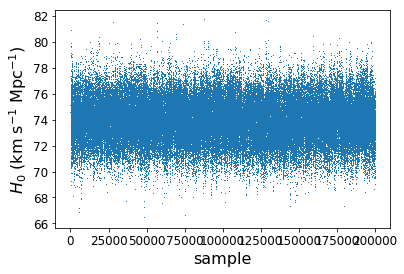

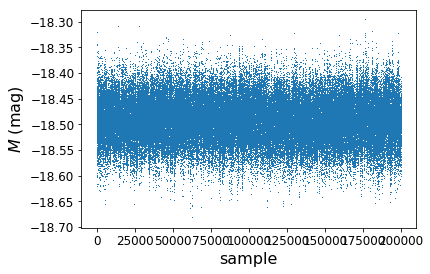

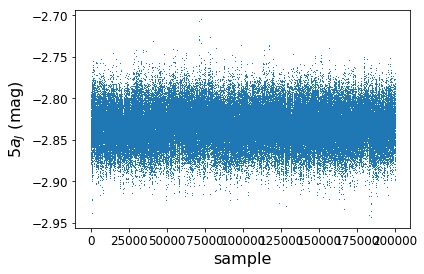

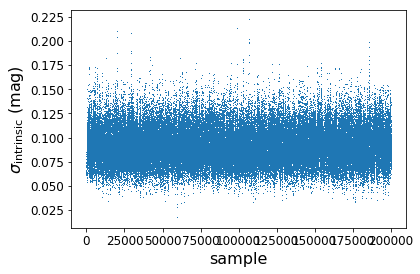

In [16]:
# plot the samples
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

# calculate -5*a_J
aj5m = -5.*np.log10(samples[:,0]) + samples[:,1] + 25
samples = np.insert(samples,2,aj5m,axis=1)


slabels = [r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)", 
           r"$M$ (mag)",
           r"$5 a_J$ (mag)",
           "",
           r"$\sigma_{\mathrm{intrinsic, hflow}}$ (mag)" ]

if nscatter == 2:
    slabels[3] = r"$\sigma_{\mathrm{intrinsic, calib}}$ (mag)"
else:
    slabels[3] = r"$\sigma_{\mathrm{intrinsic}}$ (mag)"

for i in range(ndim+1):
    plt.plot(samples[:,i],marker=',',linestyle='None')
    plt.xlabel("sample",fontsize=16)
    plt.ylabel(slabels[i],fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

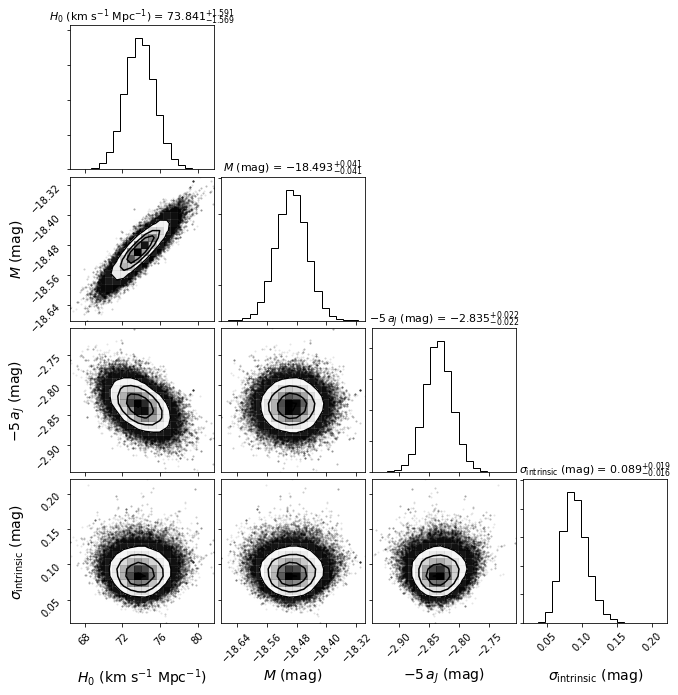

In [17]:
# make corner plot showing parameter distributions and covariances
tlabels = [r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)", 
           r"$M$ (mag)",
           r"$-5\,a_J$ (mag)",
           "",
           r"$\sigma_{\mathrm{int, hflow}}$ (mag)" ]

if nscatter == 2:
    tlabels[3] = r"$\sigma_{\mathrm{int, calib}}$ (mag)"
else:
    tlabels[3] = r"$\sigma_{\mathrm{intrinsic}}$ (mag)"

figcorner = corner.corner(samples, labels=tlabels[0:ndim+1], 
                    show_titles=True, title_fmt=".3f", verbose=True,
                    title_kwargs={"fontsize": 11}, label_kwargs={"fontsize": 14})
if individual_plots:
    figcorner.savefig(pdf_basename+"_corner.pdf",bbox_inches="tight")

In [18]:
# put all plots into one PDF 
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_basename+".pdf")
pdf.savefig(figall_diag,bbox_inches="tight")
pdf.savefig(figcalib,bbox_inches="tight")
pdf.savefig(fighflow,bbox_inches="tight")
pdf.savefig(figcorner,bbox_inches="tight")
pdf.close()

In [22]:
# text output with results
labels = np.array(['H0','M','-5 a_J'])
if nscatter == 1:
    labels = np.append(labels,['sigma_int'])
elif nscatter == 2:
    labels = np.append(labels,['sigma_int_calib','sigma_int_hflow'])
    
means = np.mean(samples,axis=0)
sigma = np.std(samples,axis=0)

q = np.percentile(samples,[16,50,84],axis=0)
medians = q[1,:]
minus = q[0,:] - medians
plus = q[2,:] - medians

if nscatter == 0:
    ncchisq = cchisq
    nhchisq = hchisq
else:
    nc_unc = np.sqrt(calib_unc**2 + medians[3]**2)
    nc_wtmean = np.average(calib_data,weights=nc_unc**(-2))
    ncpull = (calib_data - nc_wtmean)/nc_unc
    ncchisq = np.sum(ncpull**2)
    nh_unc = np.sqrt(hflow_unc**2 + medians[-1]**2)
    nhpull = hr/nh_unc
    nhchisq = np.sum(nhpull**2)

print(pdf_basename + "   UT {:%Y-%m-%d %H:%M:%S}".format(datetime.datetime.utcnow()))
print("----------------------------------------------------------------------------")
print("              N   sigma   chisq  chisq_withscatter")
print("calibrators: {:2d} {:7.3f} {:7.2f} {:12.2f}".format(ncalib,sigcalib,cchisq,ncchisq))
print("Hubble flow: {:2d} {:7.3f} {:7.2f} {:12.2f}".format(nhflow,sighr,hchisq,nhchisq))
print()
print("                            mean  sigma       median  -err   +err")

for i in range(ndim+1):
    print("{:25} {:7.3f} {:5.3f} {:12.3f} {:+6.3f} {:+6.3f}".format(
          labels[i]+":",means[i],sigma[i],medians[i],minus[i],plus[i]))

with open(pdf_basename+".out","w") as f:
    print("# " + pdf_basename + "   UT {:%Y-%m-%d %H:%M:%S}".format(datetime.datetime.utcnow()), file=f)
    print("# ----------------------------------------------------------------------------", file=f)
    print("#                          N   sigma   chisq  chisq_withscatter", file=f)
    print("calibrators: {:15d} {:7.3f} {:7.2f} {:12.2f}".format(ncalib,sigcalib,cchisq,ncchisq), file=f)
    print("Hubble flow: {:15d} {:7.3f} {:7.2f} {:12.2f}".format(nhflow,sighr,hchisq,nhchisq), file=f)
    print("# ", file=f)
    print("#                            mean  sigma            median  -err   +err", file=f)
    for i in range(ndim+1):
        print("{:25}  {:7.3f} {:5.3f} {:17.3f} {:+6.3f} {:+6.3f}".format(
              labels[i]+":",means[i],sigma[i],medians[i],minus[i],plus[i]), file=f)
    print("# ",file=f)
    print("{:25}  ${:5.2f} \pm {:4.2f}$        ${:5.2f}_".format("H0 (latex):",means[0],sigma[0],medians[0]) +
          r"{" + "{:+5.2f}".format(minus[0]) + r"}^{" + "{:+5.2f}".format(plus[0]) + r"}$", file=f)
    for i in range(1,ndim+1):
        print("{:25} ${:7.3f} \pm {:5.3f}$     ${:7.3f}_".format(labels[i]+" (latex):",means[i],sigma[i],medians[i]) +
              r"{" + "{:+6.3f}".format(minus[i]) + r"}^{" + "{:+6.3f}".format(plus[i]) + r"}$", file=f)
    print("# ----------------------------------------------------------------------------", file=f)
    if nscatter == 1:
        print(r"${:5.2f} \pm {:4.2f}$ & ${:7.3f} \pm {:5.3f}$".format(means[0],sigma[0],means[1],sigma[1]) +
              r" & ${:7.3f} \pm {:5.3f}$ & ${:7.3f} \pm {:5.3f}$ \\".format(means[2],sigma[2],means[3],sigma[3]),
              file=f)
        print("# ----------------------------------------------------------------------------", file=f)
        print("# copy and paste into results table (update first column to better description): ",file=f)
        print(pdf_basename + " & {:2d} & {:6.3f} & {:2d} & {:6.3f} & ".format(ncalib,sigcalib,nhflow,sighr),
              file=f)
        print("${:5.2f}_".format(medians[0]) 
              + r"{" + "{:+5.2f}".format(minus[0]) + r"}^{" + "{:+5.2f}".format(plus[0]) + r"}$ & "
              + "${:6.3f}_".format(medians[1]) 
              + r"{" + "{:+6.3f}".format(minus[1]) + r"}^{" + "{:+6.3f}".format(plus[1]) + r"}$ & ", file=f)
        print("${:6.3f}_".format(medians[2]) 
              + r"{" + "{:+6.3f}".format(minus[2]) + r"}^{" + "{:+6.3f}".format(plus[2]) + r"}$ & " 
              + "${:6.3f}_".format(medians[3]) 
              + r"{" + "{:+6.3f}".format(minus[3]) + r"}^{" + "{:+6.3f}".format(plus[3]) + r"}$ \\", file=f)
        print("# ----------------------------------------------------------------------------", file=f)
        

H0-cardona-znedfinal-sigcz=150   UT 2017-06-26 22:53:33
----------------------------------------------------------------------------
              N   sigma   chisq  chisq_withscatter
calibrators:  9   0.133   33.14        12.25
Hubble flow: 27   0.106   62.84        20.41

                            mean  sigma       median  -err   +err
H0:                        73.852 1.612       73.841 -1.569 +1.591
M:                        -18.493 0.042      -18.493 -0.041 +0.041
-5 a_J:                    -2.834 0.022       -2.835 -0.022 +0.022
sigma_int:                  0.090 0.018        0.089 -0.016 +0.019
